In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import csv
from datetime import datetime
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/realtor-data.zip.csv')

In [ ]:
data.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [ ]:
df_cleaned = data.drop_duplicates()

In [ ]:
# filtering out the state of New York
ny = df_cleaned[df_cleaned.state == 'New York']

In [ ]:
# filtering out NYC areas
nyc_areas = ['Manhattan', 'Brooklyn', 'Queens','Bronx', 'Staten Island', 'New York',
             'New York City','Flushing','Astoria','Williamsburg','Brooklyn Heights','Bushwick',
             'Long Island City','Jamaica','Riverdale',]
nyc = ny[ny['city'].isin(nyc_areas)]

In [ ]:
# extracting entries with date exist
nyc_date_exist = nyc[nyc.prev_sold_date.notna()]

In [ ]:
# converting to datetime and sorting
nyc_date_exist.prev_sold_date = pd.to_datetime(nyc_date_exist['prev_sold_date'])
nyc_date_exist_date_sorted = nyc_date_exist.sort_values(by='prev_sold_date')

<ipython-input-8-3ca2b1464c38>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_date_exist.prev_sold_date = pd.to_datetime(nyc_date_exist['prev_sold_date'])


In [ ]:
# adding new feature in price per square feet
nyc_date_exist_date_sorted['price/sqr_ft'] = nyc_date_exist_date_sorted['price']/nyc_date_exist_date_sorted['house_size']

In [ ]:
outlier_indices = nyc_date_exist_date_sorted[nyc_date_exist_date_sorted['price/sqr_ft'] > 50000].index
nyc_date_exist_date_sorted = nyc_date_exist_date_sorted.drop(outlier_indices)

In [ ]:
nyc_date_exist_date_sorted = nyc_date_exist_date_sorted[nyc_date_exist_date_sorted['prev_sold_date'].dt.year>1980]

In [ ]:
average_price_per_year = nyc_date_exist_date_sorted.groupby(nyc_date_exist_date_sorted['prev_sold_date'].dt.year)['price/sqr_ft'].mean()
median_price_per_year = nyc_date_exist_date_sorted.groupby(nyc_date_exist_date_sorted['prev_sold_date'].dt.year)['price/sqr_ft'].median()

In [ ]:
# naming cleaned data to df
df = nyc_date_exist_date_sorted

In [ ]:
df.head()
df = df.drop(columns=['city','state','zip_code'])

In [ ]:
df['b*b'] = df['bed'] * df['bath']

In [ ]:
df['years_since_sold'] = (datetime.now() - df['prev_sold_date']).dt.days / 365.25

In [ ]:
df['year'] = df['prev_sold_date'].dt.year

##NaN Values

In [ ]:
df_cleaned = df.dropna()


## Modeling



In [ ]:
train = df_cleaned['prev_sold_date'].dt.year <= 2021
test = df_cleaned['prev_sold_date'].dt.year == 2022

In [ ]:
df_cleaned[train].head()

,status,bed,bath,acre_lot,house_size,prev_sold_date,price,price/sqr_ft,b*b,years_since_sold,year
1015193,for_sale,5.0,3.0,0.05,1808.0,1981-01-01,989000.0,547.013274,15.0,43.006160,1981
513725,for_sale,4.0,3.0,0.04,2080.0,1981-01-01,699000.0,336.057692,12.0,43.006160,1981
1017099,for_sale,3.0,2.0,0.04,1296.0,1981-07-01,798000.0,615.740741,6.0,42.510609,1981
469251,for_sale,9.0,3.0,0.07,3926.0,1981-09-01,899000.0,228.986246,27.0,42.340862,1981
482801,for_sale,6.0,8.0,0.02,7470.0,1981-09-16,1995000.0,267.068273,48.0,42.299795,1981


In [ ]:
Y = df_cleaned[train][['price']]
X_1 = df_cleaned[train][['year','bed', 'bath', 'acre_lot','house_size' ,
                 'b*b', 'years_since_sold']]
X_2 = df_cleaned[train][['year','house_size','b*b']]
X_3 = df_cleaned[train][['bed', 'bath','acre_lot','house_size','b*b']]
model_1 = LinearRegression().fit(X_1, Y)
model_2 = LinearRegression().fit(X_2, Y)
model_3 = LinearRegression().fit(X_3, Y)

In [ ]:
pred_m1 = model_1.predict(df_cleaned[test][['year','bed', 'bath', 'acre_lot', 'house_size',
                                            'b*b', 'years_since_sold']])
pred_m2 = model_2.predict(df_cleaned[test][['year','house_size','b*b']])
pred_m3 = model_3.predict(df_cleaned[test][['bed', 'bath','acre_lot','house_size','b*b']])

In [ ]:
m1_mse = mean_squared_error(df_cleaned[test]['price'], pred_m1)
m2_mse = mean_squared_error(df_cleaned[test]['price'], pred_m2)
m3_mse = mean_squared_error(df_cleaned[test]['price'], pred_m3)

## Regressing Price on House Size

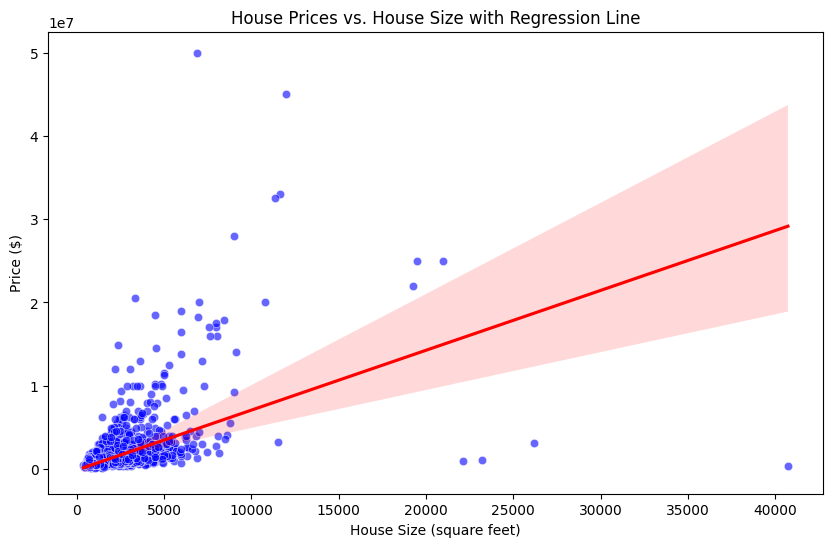

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='house_size', y='price', data=df_cleaned, color='blue', alpha=0.6)

# Plotting the regression line using Seaborn's regplot
sns.regplot(x='house_size', y='price', data=df_cleaned, scatter=False, color='red')
plt.title('House Prices vs. House Size with Regression Line')
plt.xlabel('House Size (square feet)')
plt.ylabel('Price ($)')
plt.show()

**Cook's Distance to Identify Outliers**

In [ ]:
X_with_constant = sm.add_constant(df_cleaned['house_size'])
model = sm.OLS(df_cleaned['price'], X_with_constant).fit()
influence = model.get_influence()

# Obtain Cook's distance for each observation
cooks_d = influence.cooks_distance

# The cooks_d object contains two arrays: the Cook's distance values and p-values.
# We're interested in the first array, which is the Cook's distance values.
cook_values = cooks_d[0]
p_values = cooks_d[1]

In [ ]:
n = X_with_constant.shape[0]
k = X_with_constant.shape[1] - 1
threshold = 4 / (n - k - 1)

# Identify observations where Cook's distance is greater than the threshold
outliers_indices = np.where(cook_values > threshold)[0]

In [ ]:
df_cleaned.reset_index()

,index,status,bed,bath,acre_lot,house_size,prev_sold_date,price,price/sqr_ft,b*b,years_since_sold,year
0,1015193,for_sale,5.0,3.0,0.05,1808.0,1981-01-01,989000.0,547.013274,15.0,43.006160,1981
1,513725,for_sale,4.0,3.0,0.04,2080.0,1981-01-01,699000.0,336.057692,12.0,43.006160,1981
2,1017099,for_sale,3.0,2.0,0.04,1296.0,1981-07-01,798000.0,615.740741,6.0,42.510609,1981
3,469251,for_sale,9.0,3.0,0.07,3926.0,1981-09-01,899000.0,228.986246,27.0,42.340862,1981
4,482801,for_sale,6.0,8.0,0.02,7470.0,1981-09-16,1995000.0,267.068273,48.0,42.299795,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
3004,1019133,for_sale,3.0,4.0,0.14,3145.0,2022-04-01,1675000.0,532.591415,12.0,1.760438,2022
3005,744176,for_sale,4.0,3.0,0.29,2250.0,2022-04-01,4500000.0,2000.000000,12.0,1.760438,2022
3006,1018057,for_sale,9.0,8.0,0.04,3750.0,2022-04-04,1990000.0,530.666667,72.0,1.752225,2022
3007,732034,for_sale,4.0,5.0,0.18,4275.0,2022-04-04,9000000.0,2105.263158,20.0,1.752225,2022


In [ ]:
df_removed_outlier = df_cleaned.drop(df_cleaned.index[outliers_indices])

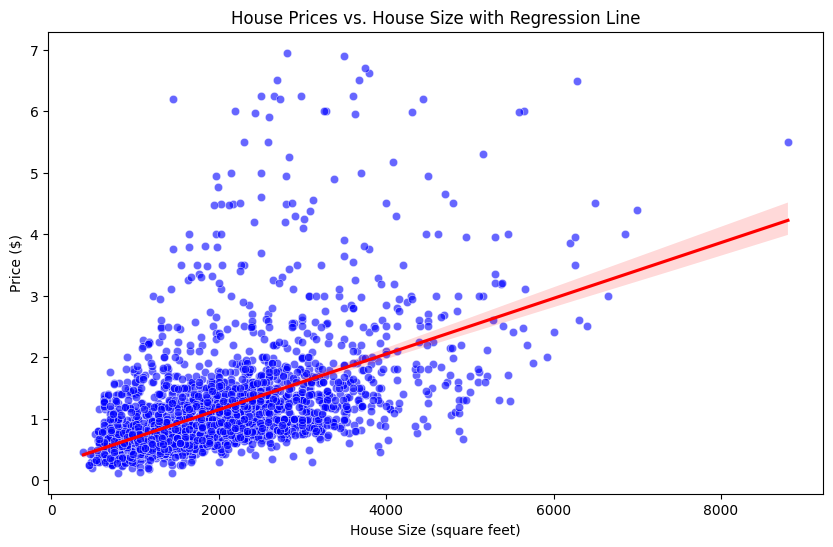

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='house_size', y='price', data=df_removed_outlier, color='blue', alpha=0.6)

# Plotting the regression line using Seaborn's regplot
sns.regplot(x='house_size', y='price', data=df_removed_outlier, scatter=False, color='red')
plt.title('House Prices vs. House Size with Regression Line')
plt.xlabel('House Size (square feet)')
plt.ylabel('Price ($)')
plt.show()

In [ ]:
df_removed_outlier.reset_index()

,index,status,bed,bath,acre_lot,house_size,prev_sold_date,price,price/sqr_ft,b*b,years_since_sold,year
0,1015193,for_sale,5.0,3.0,0.05,1808.0,1981-01-01,989000.0,547.013274,15.0,43.006160,1981
1,513725,for_sale,4.0,3.0,0.04,2080.0,1981-01-01,699000.0,336.057692,12.0,43.006160,1981
2,1017099,for_sale,3.0,2.0,0.04,1296.0,1981-07-01,798000.0,615.740741,6.0,42.510609,1981
3,469251,for_sale,9.0,3.0,0.07,3926.0,1981-09-01,899000.0,228.986246,27.0,42.340862,1981
4,1014872,for_sale,3.0,2.0,0.05,1645.0,1981-10-01,1200000.0,729.483283,6.0,42.258727,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
2929,1017151,for_sale,1.0,1.0,0.07,467.0,2022-04-01,425000.0,910.064240,1.0,1.760438,2022
2930,1019133,for_sale,3.0,4.0,0.14,3145.0,2022-04-01,1675000.0,532.591415,12.0,1.760438,2022
2931,744176,for_sale,4.0,3.0,0.29,2250.0,2022-04-01,4500000.0,2000.000000,12.0,1.760438,2022
2932,1018057,for_sale,9.0,8.0,0.04,3750.0,2022-04-04,1990000.0,530.666667,72.0,1.752225,2022


In [ ]:
df_removed_outlier_mil = df_removed_outlier
df_removed_outlier_mil['price'] = df_removed_outlier_mil['price']/1000000

In [ ]:
Y_NO = df_removed_outlier_mil[train][['price']]
X_NO = df_removed_outlier_mil[train][['year','acre_lot','house_size','b*b']]
X_test = df_removed_outlier_mil[test][['year','acre_lot','house_size','b*b']]

model_1NO = LinearRegression().fit(X_NO, Y_NO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_NO)
X_test_scaled = scaler.transform(X_test)
ridge_model = Ridge(alpha=1.0).fit(X_train_scaled, Y_NO) # alpha is the regularization strength

pred_m1NO = model_1NO.predict(df_removed_outlier_mil[test][['year','acre_lot','house_size' ,'b*b']])
pred_ridge = ridge_model.predict(X_test_scaled)

m1NO_mse = mean_squared_error(df_removed_outlier_mil[test]['price'], pred_m1NO)
m2NO_mse = mean_squared_error(df_removed_outlier_mil[test]['price'], pred_ridge)

In [ ]:
((m1NO_mse - m2NO_mse)/m1NO_mse) * 100

-0.006532036683609185

In [ ]:
df_removed_outlier_mil.to_csv('/content/drive/MyDrive/df_removed_outlier_mil.csv', index=False)


In [ ]:
X = df_removed_outlier_mil[['house_size','b*b','acre_lot','year']]
y = df_removed_outlier_mil['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Create a Random Forest Regressor model
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model_RF.fit(X_train, y_train)

# Make predictions
y_pred = model_RF.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
model_RF.score(X_test, y_test)

0.43550368915957394

In [ ]:
mse

0.32982102893684656

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Check stationarity
result = adfuller(df_removed_outlier_mil['price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -54.284069
p-value: 0.000000


In [ ]:
plot_acf(df_removed_outlier_mil['price'].dropna())
plot_pacf(df_removed_outlier_mil['price'].dropna(), method='ywm')

In [ ]:
# Fit ARIMA model
# Replace p, d, q with the identified values
model = ARIMA(df_removed_outlier_mil['price'], order=(1, 0, 8))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast
forecast = model_fit.get_forecast(steps=5)
print(forecast.summary_frame())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2934
Model:                 ARIMA(1, 1, 8)   Log Likelihood               -3715.515
Date:                Thu, 04 Jan 2024   AIC                           7451.030
Time:                        03:41:16   BIC                           7510.867
Sample:                             0   HQIC                          7472.578
                               - 2934                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8145      0.215     -3.783      0.000      -1.237      -0.393
ma.L1         -0.1856      0.216     -0.857      0.391      -0.610       0.239
ma.L2         -0.8032      0.217     -3.697      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
y_pred0 = model_fit.forecast(steps=len(y_test))
mse0 = mean_squared_error(y_test, y_pred0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
mse0

0.6823333199202446

##Evaluting Model

In [ ]:
train = df_removed_outlier_mil['year'] <= 2021
test = df_removed_outlier_mil['year'] == 2022
Y = df_removed_outlier_mil[train][['price']]
X = df_removed_outlier_mil[train][['house_size','b*b','acre_lot','year']]

model_base = LinearRegression().fit(X, Y)
pred_base = model_base.predict(df_removed_outlier_mil[test][['house_size','b*b','acre_lot','year']])
base_mse = mean_squared_error(df_removed_outlier_mil[test]['price'], pred_base)

In [ ]:
((base_mse - mse)/base_mse) * 100

76.38155311147246

In [ ]:
var = df_removed_outlier_mil['price'].var()

In [ ]:
((var - mse0)/var) * 100

7.218213771648507

In [ ]:
X = df_removed_outlier_mil[['house_size','b*b','acre_lot','year']]
y = df_removed_outlier_mil['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

mean_prediction = np.mean(y_train)
median_prediction = np.median(y_train)

mean_predictions = np.full(shape=y_test.shape, fill_value=mean_prediction)
median_predictions = np.full(shape=y_test.shape, fill_value=median_prediction)

# Calculate MSE
mse_mean = mean_squared_error(y_test, mean_predictions)
mse_median = mean_squared_error(y_test, median_predictions)

In [ ]:
mse_mean

0.6827063830439156

In [ ]:
# evaluating model; comparing random forest mse to baseline mse of mean prediction
((mse_mean - mse)/mse_mean) * 100

43.689333041917436

In [ ]:
mse_mean

0.682463446874844

In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_RF, X, y, cv=5, scoring='neg_mean_squared_error')

# Since scores are negative MSE, we take the square root of the negated scores to get RMSE
cv_rmse_scores = np.sqrt(-cv_scores)

ValueError: ignored

Average RMSE from cross-validation smaller than mean of house prices, suggesting model is close to true values

In [ ]:
cv_rmse_scores.mean()

In [ ]:
df_removed_outlier_mil['price'].mean()